In [143]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib widget

In [109]:
df = pd.read_csv('final_predictions_lgbm.csv')

# filter out values greater than two standard deviations from the mean
pv_mean = df['PRICE_VAR'].mean()
pv_std = df['PRICE_VAR'].std()
# outliers = df[df['PRICE_VAR'] > 2*pv_std + pv_mean]
outliers = df[df['PRICE_VAR'] > 1000]
print(outliers.head(20))
df = df[~df['company'].isin(outliers['company'])]

pv_mean = df['PRICE_VAR'].mean()
pv_std = df['PRICE_VAR'].std()

print(pv_mean, pv_std)
df = df.pivot(index='company', columns='year', values=['lgb_pred', 'PRICE_VAR'])
df.head(10)

# df14 = df.loc[:, (slice(None), 2014)]

      Unnamed: 0 company  year  test  Class     PRICE_VAR  lgb_pred  lgb_keep
55           206      CC  2014     1      1  2.248621e+03  0.363237         0
189          739     PEN  2014     1      1  9.864815e+03  0.497284         0
524         2068     GNL  2014     1      1  2.418601e+06  0.599058         1
552         2170    YRIV  2014     1      1  2.933333e+03  0.569465         1
807         3290     BKI  2014     1      1  6.602000e+04  0.631808         1
2360       10196    INVH  2016     1      1  1.072070e+04  0.727050         1
2778       12618     LOV  2016     1      1  1.275000e+03  0.568287         1
7.422961730732691 50.44526396881603


lgb_pred                                          PRICE_VAR  \
year         2014      2015      2016      2017      2018       2014   
company                                                                
AA       0.540425  0.687972  0.477526  0.318061  0.463715 -37.203411   
AABA     0.620936  0.631229  0.655892  0.680091  0.693351 -33.705402   
AAPL     0.723149  0.744538  0.774197  0.733244  0.828690  -2.082268   
AAXN     0.624681  0.619697  0.575034  0.702837  0.701715 -34.779326   
AB       0.629259  0.699304  0.616548  0.673084  0.774163  -2.130572   
ABG      0.611774  0.732499  0.600511  0.571798  0.511188 -11.368109   
ABIL     0.543928  0.494086  0.375161  0.444530  0.244051   0.000000   
ACHN     0.387376  0.429903  0.458033  0.567803  0.519025 -19.054764   
ACN      0.497377  0.804931  0.748632  0.511060  0.801680  21.487040   
ACNB     0.885523  0.917341  0.497229  0.366749  0.847603   3.747116   

                                                       
year          2015       2016        2017        2018  
company                                                
AA       22.046441  86.853968  -51.821641  -18.025913  
AABA     23.152870  79.562978  -20.771226   25.257522  
AAPL     12.384342  48.042508   -7.054338   88.742465  
AAXN     44.028520   7.811229   64.783432   62.447346  
AB        7.876336  13.842448   20.323288   20.073428  
ABG      -7.245935   2.400000    5.391310   64.107452  
ABIL    -72.736220 -84.722223  307.725325  -83.615385  
ACHN    -60.096619 -29.927007  -48.543687  256.804734  
ACN      17.350039  34.103019   -6.685851   51.665345  
ACNB     51.107154  -3.343251   35.564107    0.557013

In [110]:
pred = df.loc[:, 'lgb_pred'].to_numpy()
perf = df.loc[:, 'PRICE_VAR'].to_numpy()

In [111]:
np.any(np.isnan(pred))
nan_indices = np.where(np.isnan(pred))
print(nan_indices)  # Output: Indices of NaN values

(array([], dtype=int64), array([], dtype=int64))


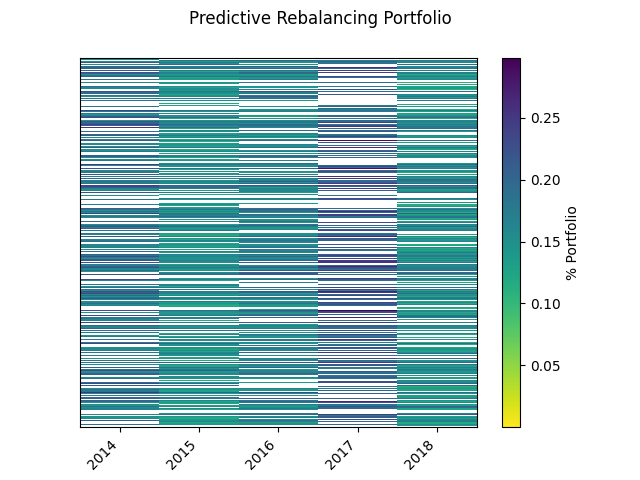

In [146]:
plt.close('all')
pred[pred<.5] = 0  # divest out of stocks we predict will lose money
prop = pred / pred.sum(axis=0)

cmap = plt.get_cmap('viridis_r')
cmap.set_under('white')
eps = np.spacing(0.0)
fig, ax = plt.subplots()
im = ax.imshow(prop*100, interpolation='none', aspect='auto', vmin=1e-5, cmap=cmap,)

cbar = fig.colorbar(im)
cbar.set_label('% Portfolio')
# fig.colorbar(im, extend='min')
fig.suptitle('Predictive Rebalancing Portfolio')

ax.set_xlim(-0.5, prop.shape[1] - 0.5)
ax.set_ylim(prop.shape[0] - 0.5, -2)
ax.set_xticks(np.arange(5))
ax.set_xticklabels([str(2014+i) for i in range(5)], rotation=45, ha='right')
ax.set_yticks([])

plt.show()

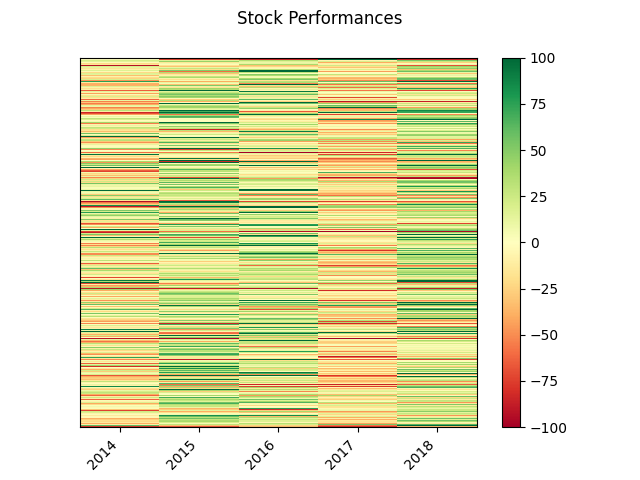

In [113]:
plt.close('all')
cmap = plt.get_cmap('RdYlGn')
eps = np.spacing(0.0)
fig, ax = plt.subplots()
# im = ax.imshow(perf, interpolation='none', aspect='auto', cmap=cmap, norm=LogNorm(vmin=.01, vmax=perf.max()))
im = ax.imshow(perf, interpolation='none', aspect='auto', cmap=cmap, norm=TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100))
fig.colorbar(im)
fig.suptitle('Stock Performances')

ax.set_xlim(-0.5, perf.shape[1] - 0.5)
ax.set_ylim(perf.shape[0] - 0.5, -2)
ax.set_xticks(np.arange(5))
ax.set_xticklabels([str(2014+i) for i in range(5)], rotation=45, ha='right')
ax.set_yticks([])

plt.show()

In [114]:
strat1 = (prop*perf).sum(axis=0)/100 + 1
print(strat1)
print(np.prod(strat1)*100)

[1.00354382 1.24738369 1.1710292  0.9340631  1.26138521]
172.71421127290205


In [115]:
uniform = np.ones(perf.shape)
uniform /= uniform.sum(axis=0)
uniform.sum(axis=0)
strat2 = (uniform*perf).sum(axis=0)/100 + 1
print(strat2)
print(np.prod(strat2)*100)

[0.96491079 1.17832732 1.16704412 0.85604479 1.20482107]
136.85460811711937


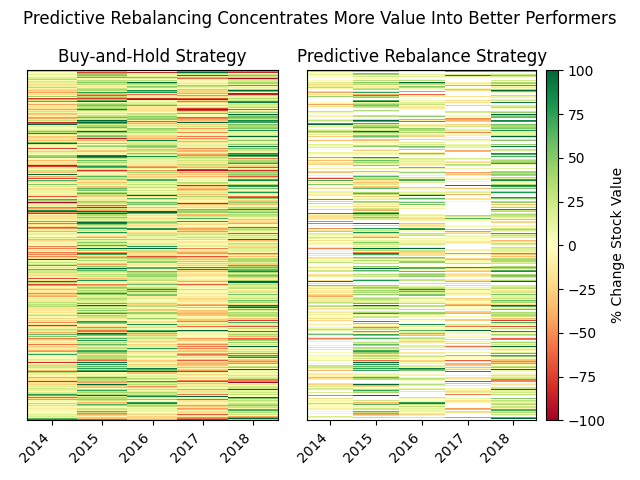

In [147]:
perf2 = perf.copy()
perf2[prop == 0] = 0
perf2 = np.ma.masked_where(prop == 0, perf)

plt.close('all')
cmap = plt.get_cmap('RdYlGn')
cmap.set_bad('white')
eps = np.spacing(0.0)
fig, axs = plt.subplots(ncols=2)
# im = ax.imshow(perf, interpolation='none', aspect='auto', cmap=cmap, norm=LogNorm(vmin=.01, vmax=perf.max()))
im = axs[0].imshow(perf, interpolation='none', aspect='auto', cmap=cmap, norm=TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100))
im2 = axs[1].imshow(perf2, interpolation='none', aspect='auto', cmap=cmap, norm=TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100))

axs[0].set_title('Buy-and-Hold Strategy')
axs[1].set_title('Predictive Rebalance Strategy')

for ax in axs:
    ax.set_xlim(-0.5, perf.shape[1] - 0.5)
    ax.set_ylim(perf.shape[0] - 0.5, -2)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels([str(2014+i) for i in range(5)], rotation=45, ha='right')
    ax.set_yticks([])

divider = make_axes_locatable(axs[1])  # Add space to the second subplot
cax = divider.append_axes("right", size="5%", pad=0.1)  # Size and padding for the colorbar

# Add the colorbar
cbar = fig.colorbar(im2, cax=cax)

cbar.set_label('% Change Stock Value')
fig.suptitle('Predictive Rebalancing Concentrates More Value Into Better Performers')

plt.tight_layout()
plt.show()

In [122]:
mask = prop != 0
s1 = perf[mask]

In [126]:
mask.shape

(925, 5)

In [130]:
perf2 = perf.copy()
perf2[prop == 0] = 0

Unnamed: 0              2068
company                  GNL
year                    2014
test                       1
Class                      1
PRICE_VAR     2418600.915311
lgb_pred            0.599058
lgb_keep                   1
Name: 524, dtype: object